# General data analysis

Idea: test on jupyternotebok and then create final function to run using a for loop on both dataset

NB: inspired by the events_analysis.py from MRP

## Initialization

In [2]:
import json
import math
import random
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys

In [3]:
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    

print(project_root)

c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub


In [4]:
from event_model import event_model as em
import data_analysis.event_generator as eg
from algorithms import clustering
from algorithms.clustering import Clustering
from validator.validator_lite import MCParticle

In [5]:
def data_distribution(data):
    total = 0
    for num in data:
        total += num

    mu = total / len(data)

    aux = 0
    for num in data:
        aux += ((num - mu) ** 2)

    variance = aux / len(data)
    sigma = math.sqrt(variance)

    print(f'Mean: {mu}')
    print(f'Variance: {variance}')
    print(f'Standard deviation: {sigma}')

    return mu, variance, sigma

In [38]:
def plot_distribution(mu, sigma, title='Distribution', xlabel='Data',safe_to_file=False):
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label='pdf')
    plt.title(title)
    #plt.text(-0.0008, -0.0008, f'$\mu={round(mu, 4)},\ \sigma={round(sigma, 4)}$')
    plt.grid(True)
    plt.xlabel(xlabel)
    
    # set x-axis limits to full range of distribution
    plt.xlim(mu - 4 * sigma, mu + 4 * sigma)
    
    if safe_to_file:
        plt.savefig(f'event_plots/{title}', bbox_inches='tight', pad_inches=0.2)
        plt.close()
    else:
        plt.show()

In [7]:
def get_bins(x):
    q25, q75 = np.percentile(x, [.25, .75])
    bin_width = 2 * (q75 - q25) * len(x) ** (-1 / 3)
    bins = round((x.max() - x.min()) / bin_width)
    print("Freedman–Diaconis number of bins:", bins)
    return bins

In [63]:
def plot_density_histogram(data, title="Histogram", xlabel="Data", ylabel="", safe_to_file=False):
    x = np.array(data)
    counts, bins, _ = plt.hist(x, bins=100, color='skyblue', alpha=0.5, edgecolor='blue'
                               #, label='# of hits', bins = get_bins(x)
                               )
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True, color='grey', linewidth=0.5)
    plt.title(title)

    kde_xs = np.linspace(np.min(x), np.max(x), 300)
    kde = stats.gaussian_kde(x)
    plt.plot(kde_xs, kde.pdf(kde_xs) * len(x) * np.diff(bins)[0], label="Gaussian distribution")

    plt.legend(loc="upper right")
    plt.tight_layout()

    if safe_to_file:
        plt.savefig(f'event_plots/{title}', bbox_inches='tight', pad_inches=0.2)
        plt.close()
    else:
        plt.show()

In [9]:
def plot_histogram(data, title="Histogram", xlabel="Data", ylabel="", safe_to_file=False):
    x = np.array(data)
    plt.hist(x, 100, color='skyblue', alpha=0.5, edgecolor='blue')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True, color='grey', linewidth=0.5)
    plt.title(title)
    if safe_to_file:
        plt.savefig(f'event_plots/{title}', bbox_inches='tight', pad_inches=0.2)
        plt.close()
    else:
        plt.show()

## 1. Number of hits by events (total, pur, noisy)

In [10]:
def get_json_data_from_folder(data_set_folder):
    jsons = []
    # for (dirpath, dirnames, filenames) in os.walk(f"../events/{data_set_folder}"):
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(project_root, f"datasets/{data_set_folder}")):
        filenames = sorted(filenames, key=lambda filename: int(filename.replace('velo_event_', '').replace('.json', '')))
        for i, filename in enumerate(filenames):
            # Get an event
            # print(f'opening: {filename}')
            f = open(os.path.realpath(os.path.join(dirpath, filename)))
            json_data = json.loads(f.read())
            event = em.event(json_data)
            f.close()
            # print(f'closing : {filename}')

            jsons.append(json_data)
    return jsons

In [11]:
jsons = get_json_data_from_folder('minibias')


In [12]:
print(len(jsons))

995


In [13]:
def tracks_from_data(json_data, only_reconstructible=True):
    reconstructible_tracks = []
    hits = []
    counter = 0
    for hid, (x, y, z) in enumerate(zip(json_data["x"], json_data["y"], json_data["z"])):
        hits.append(em.hit(x, y, z, hid))
        
    description = json_data["montecarlo"]["description"]
    particles = json_data["montecarlo"]["particles"]

    for p in particles:
        d = {description[i]: p[i] for i in range(len(description))}
        track_hits = [hits[hit_number] for hit_number in d["hits"]]
        
        if only_reconstructible:
            if len(track_hits) >= 3:
                reconstructible_tracks.append(em.track(track_hits))
        else:
            reconstructible_tracks.append(em.track(track_hits))

    return reconstructible_tracks, hits

In [14]:
reconstructible_tracks_list = []
hits_list = []
nr_hits_list = []
for event in jsons:
    tracks, hits = tracks_from_data(event, True)
    reconstructible_tracks_list.append(tracks)
    hits_list.append(hits)
    nr_hits_list.append(len(hits))


In [15]:
#print(nr_hits_list)

> total number of hits in the event

In [16]:
total = 0
for num in nr_hits_list:
    total += num
print(total)

1954057


In [17]:
mu, var, sigma = data_distribution(nr_hits_list)

Mean: 1963.8763819095477
Variance: 1208248.6389899263
Standard deviation: 1099.2036385447086


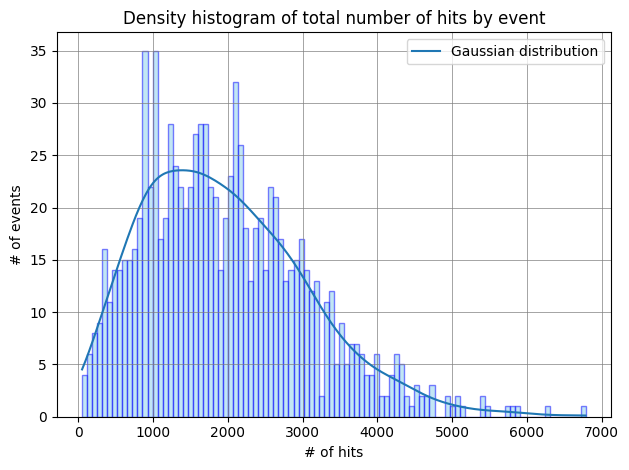

In [64]:
plot_density_histogram(nr_hits_list, title="Density histogram of total number of hits by event", xlabel="# of hits", ylabel="# of events", safe_to_file=False)

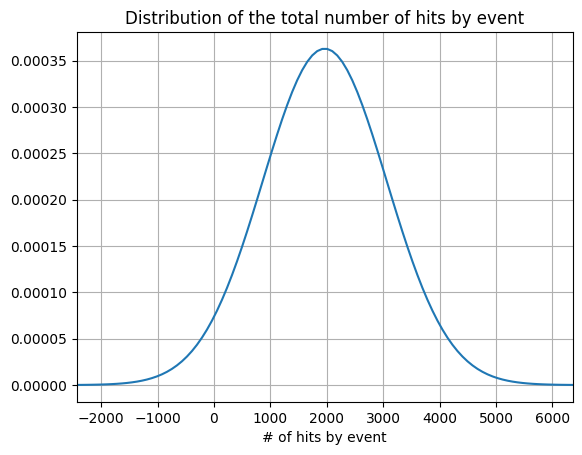

In [39]:
plot_distribution(mu, sigma, title='Distribution of the total number of hits by event', xlabel = '# of hits by event',safe_to_file=False)

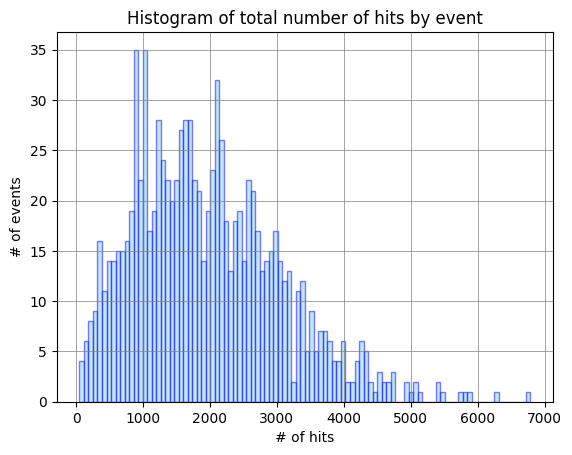

In [57]:
plot_histogram(nr_hits_list, title="Histogram of total number of hits by event", xlabel="# of hits", ylabel="# of events", safe_to_file=False)

## Noise


In [21]:
def noise_from_data(json_data,only_reconstructible=True):
    noise = 0
    hits_in_reconstructible_tracks = 0
    tracks = []
    hits = []
    for hid, (x, y, z) in enumerate(zip(json_data["x"], json_data["y"], json_data["z"])):
        hits.append(em.hit(x, y, z, hid))


    description = json_data["montecarlo"]["description"]
    particles = json_data["montecarlo"]["particles"]

    for p in particles:
        d = {description[i]: p[i] for i in range(len(description))}
        track_hits = [hits[hit_number] for hit_number in d["hits"]]

        if only_reconstructible:
            if len(track_hits) >= 3:
                hits_in_reconstructible_tracks += len(track_hits)
        else:
            hits_in_reconstructible_tracks += len(track_hits)

    noise = len(hits) - hits_in_reconstructible_tracks
    return noise

In [22]:
nr_noise_list = []
for event in jsons:
    noise = noise_from_data(event,True)
    nr_noise_list.append(noise)

In [23]:
print(len(nr_noise_list))
print((nr_noise_list[2]))

995
5


> number of noise hits in the event

In [24]:
mu_noise, var_noise, sigma_noise = data_distribution(nr_noise_list)

Mean: 214.01507537688443
Variance: 15246.028918461674
Standard deviation: 123.47481086627214


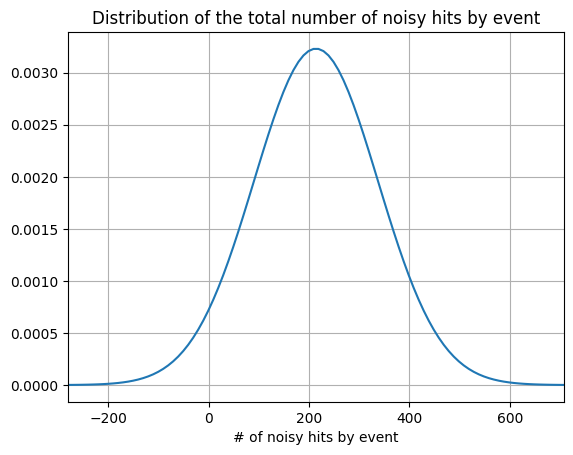

In [41]:
plot_distribution(mu_noise, sigma_noise, title='Distribution of the total number of noisy hits by event', xlabel = '# of noisy hits by event',safe_to_file=False)

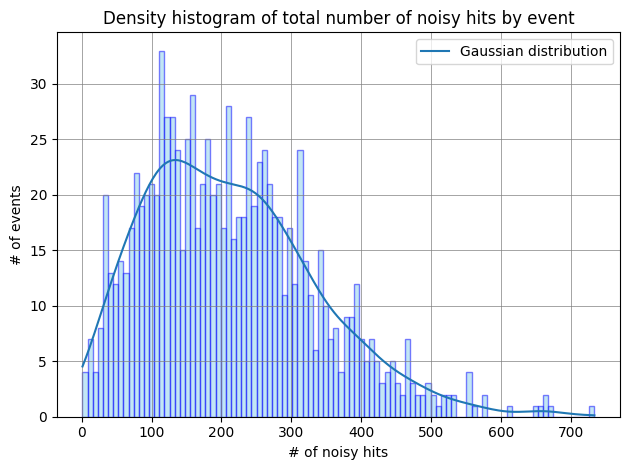

In [65]:
plot_density_histogram(nr_noise_list, title="Density histogram of total number of noisy hits by event", xlabel="# of noisy hits", ylabel="# of events", safe_to_file=False)

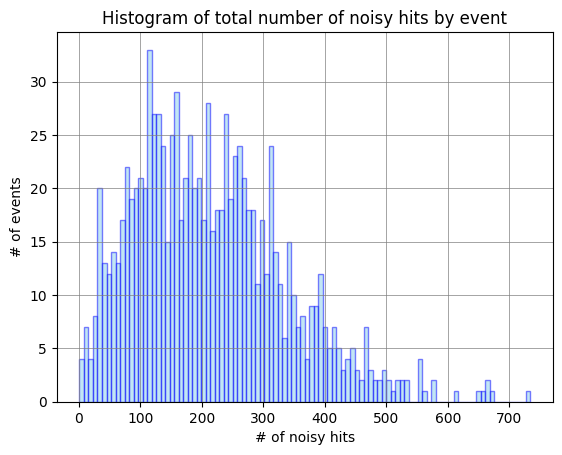

In [27]:
plot_histogram(nr_noise_list, title="Histogram of total number of noisy hits by event", xlabel="# of noisy hits", ylabel="# of events", safe_to_file=False)

In [28]:
total_hits = sum(nr_hits_list)
total_noise = sum(nr_noise_list)
percentage= total_noise/total_hits
print('Percentage of noisy hits:',percentage)

Percentage of noisy hits: 0.10897583847349386


## 2. Number of tracks by event

In [29]:
reconstructible_tracks_list = []
nr_recon_tracks_list = []

for event in jsons:
    tracks, hits = tracks_from_data(event, True)
    reconstructible_tracks_list.append(tracks)
    hits_list.append(hits)
    nr_recon_tracks_list.append(len(tracks))

In [30]:
print(len(nr_recon_tracks_list))
#print(nr_recon_tracks_list)

995


In [31]:
mu_track, var_track, sigma_track = data_distribution(nr_recon_tracks_list)

Mean: 274.2733668341709
Variance: 23791.503160021166
Standard deviation: 154.24494533053965


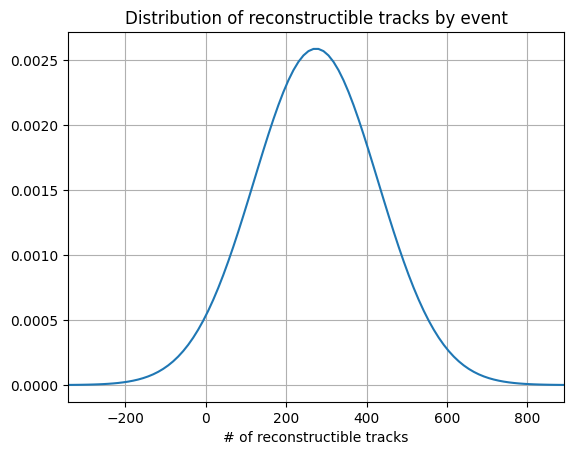

In [44]:
plot_distribution(mu_track, sigma_track, title='Distribution of reconstructible tracks by event', xlabel="# of reconstructible tracks", safe_to_file=False)

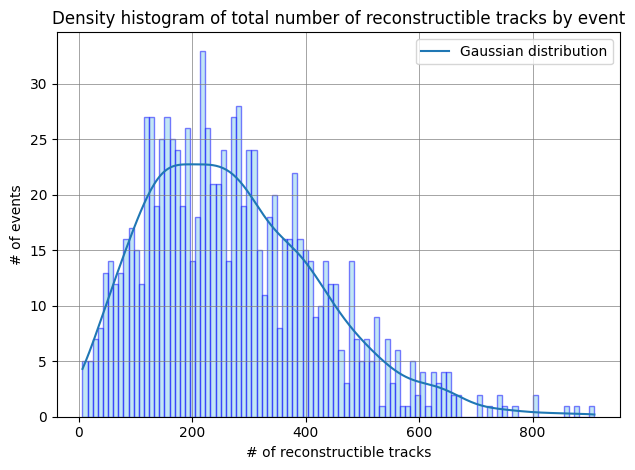

In [66]:
plot_density_histogram(nr_recon_tracks_list, title="Density histogram of total number of reconstructible tracks by event", xlabel="# of reconstructible tracks", ylabel="# of events", safe_to_file=False)

## 3. Number of hits by tracks (total = length, normal and noisy hits distribution)

In [132]:
reconstructible_tracks_list = []
nr_recon_tracks_list = []
hits_list = []

for event in jsons:
    tracks, hits = tracks_from_data(event, True)
    reconstructible_tracks_list.append(tracks)
    hits_list.append(hits)
    nr_recon_tracks_list.append(len(tracks))

In [118]:
print(len(reconstructible_tracks_list))


995


In [133]:
first_event_all_tracks = reconstructible_tracks_list[2]
print(len(first_event_all_tracks))
print(first_event_all_tracks)

13
[Track with 15 hits: [#15 module -1 {1.69, 6.806, 99.419}, #21 module -1 {1.962, 8.012, 124.419}, #27 module -1 {2.273, 9.178, 149.419}, #35 module -1 {2.565, 10.326, 174.419}, #43 module -1 {2.818, 11.512, 199.419}, #52 module -1 {3.129, 12.678, 224.419}, #63 module -1 {3.401, 13.884, 249.419}, #72 module -1 {3.712, 15.051, 274.419}, #79 module -1 {4.296, 17.423, 324.419}, #89 module -1 {5.151, 21.001, 399.419}, #99 module -1 {6.311, 25.753, 500.581}, #107 module -1 {7.439, 30.459, 600.581}, #115 module -1 {7.983, 32.792, 650.581}, #124 module -1 {8.567, 35.164, 700.581}, #132 module -1 {9.111, 37.498, 750.581}], Track with 12 hits: [#30 module -1 {-2.974, 4.354, 163.081}, #39 module -1 {-3.305, 4.879, 188.081}, #48 module -1 {-3.655, 5.385, 213.081}, #57 module -1 {-3.966, 5.929, 238.081}, #67 module -1 {-4.277, 6.396, 263.081}, #77 module -1 {-4.938, 7.446, 313.081}, #86 module -1 {-5.872, 9.001, 388.081}, #94 module -1 {-7.116, 11.102, 488.081}, #103 module -1 {-8.497, 13.221, 5

In [134]:
first_event_first_track = first_event_all_tracks[2]
print(first_event_first_track)
print(first_event_first_track.hits)
print(len(first_event_first_track.hits))

Track with 8 hits: [#3 module -1 {-5.094, 4.101, 13.081}, #7 module -1 {-7.252, 5.871, 38.081}, #9 module -1 {-9.43, 7.621, 63.081}, #12 module -1 {-11.55, 9.39, 88.081}, #19 module -1 {-13.708, 11.16, 113.081}, #26 module -1 {-15.73, 12.871, 136.919}, #33 module -1 {-17.889, 14.641, 161.919}, #41 module -1 {-19.989, 16.43, 186.919}]
[#3 module -1 {-5.094, 4.101, 13.081}, #7 module -1 {-7.252, 5.871, 38.081}, #9 module -1 {-9.43, 7.621, 63.081}, #12 module -1 {-11.55, 9.39, 88.081}, #19 module -1 {-13.708, 11.16, 113.081}, #26 module -1 {-15.73, 12.871, 136.919}, #33 module -1 {-17.889, 14.641, 161.919}, #41 module -1 {-19.989, 16.43, 186.919}]
8


fct test

In [120]:
nr_tracks_list=[]
nr_hits_list = []

for event in reconstructible_tracks_list:
    nr_tracks = len(event)
    nr_tracks_list.append(nr_tracks)
    
    for tracks in event:
        nr_hits = len(tracks.hits)
        nr_hits_list.append(nr_hits)

In [124]:
print(len(nr_tracks_list))
print(nr_tracks_list[2])

print(sum(nr_tracks_list))

print(len(nr_hits_list))
print(sum(nr_hits_list))
print(nr_hits_list[2])

print(sum(nr_hits_list)/sum(nr_tracks_list))



995
13
272902
272902
1741112
3
6.379989886479396


In [127]:
mu_track_hits, var_track_hits, sigma_track_hits = data_distribution(nr_hits_list)

Mean: 6.379989886479396
Variance: 10.1944765841683
Standard deviation: 3.192879043147156


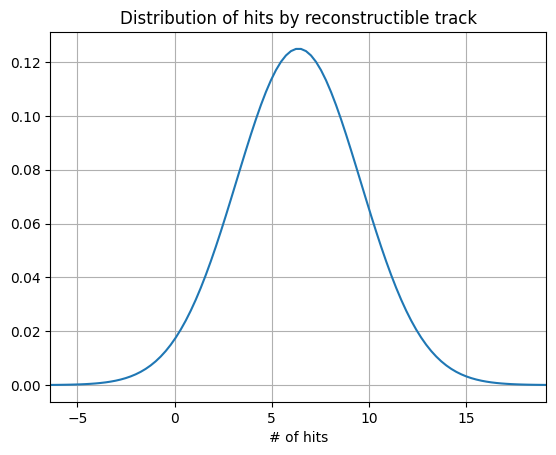

In [131]:
plot_distribution(mu_track_hits, sigma_track_hits, title='Distribution of hits by reconstructible track', xlabel="# of hits", safe_to_file=False)

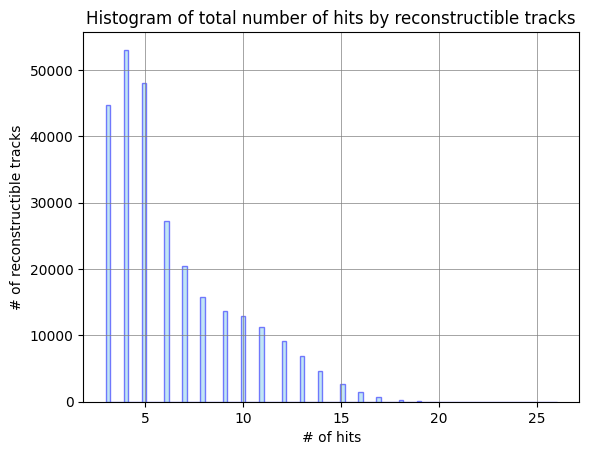

In [128]:
plot_histogram(nr_hits_list, title="Histogram of total number of hits by reconstructible tracks", xlabel="# of hits", ylabel="# of reconstructible tracks", safe_to_file=False)

## 4. Histogram with distribution of total number of hits by module + noise hits by module (MRP txt + histogram somewhere in the code)

### First approach (didn't work)

In [146]:
print(len(jsons))

995


In [187]:
def tracks_from_data(json_data, only_reconstructible=True):
    reconstructible_tracks = []
    hits = []
    track_hits_list = []

    for hid, (x, y, z) in enumerate(zip(json_data["x"], json_data["y"], json_data["z"])):
        hits.append(em.hit(x, y, z, hid))
        
    description = json_data["montecarlo"]["description"]
    particles = json_data["montecarlo"]["particles"]

    for p in particles:
        d = {description[i]: p[i] for i in range(len(description))}
        track_hits = [hits[hit_number] for hit_number in d["hits"]]
        track_hits_list.append(em.hits(track_hits))


        if only_reconstructible:
            if len(track_hits) >= 3:
                reconstructible_tracks.append(em.track(track_hits))
        else:
            reconstructible_tracks.append(em.track(track_hits))


    return reconstructible_tracks, hits, track_hits_list

In [181]:

reconstructible_tracks_list = []
hits_list = []
nr_hits_list = []
tracks_hits_list = []

for event in jsons:
    tracks, hits, tracks_hits = tracks_from_data(event, True)
    reconstructible_tracks_list.append(tracks)
    tracks_hits_list.append(tracks_hits)
    hits_list.append(hits)
    nr_hits_list.append(len(hits))


In [182]:
print(len(hits_list[2])) # ALL HITS, noisy and not noisy
print(hits_list[2])


print(len(tracks_hits_list[2]))
print(tracks_hits_list[2])

print(len(tracks_hits_list))



135
[#0 module -1 {5.855, -25.55, -138.08}, #1 module -1 {-10.752, -1.79, -11.918}, #2 module -1 {-7.289, -2.994, 11.919}, #3 module -1 {-5.094, 4.101, 13.081}, #4 module -1 {-18.978, -3.054, 13.081}, #5 module -1 {-10.439, -4.277, 36.919}, #6 module -1 {-27.339, -4.48, 38.081}, #7 module -1 {-7.252, 5.871, 38.081}, #8 module -1 {-13.747, -5.64, 63.081}, #9 module -1 {-9.43, 7.621, 63.081}, #10 module -1 {-35.37, -5.951, 61.919}, #11 module -1 {2.604, 6.125, 74.419}, #12 module -1 {-11.55, 9.39, 88.081}, #13 module -1 {-16.917, -6.943, 88.081}, #14 module -1 {-43.712, -7.552, 86.919}, #15 module -1 {1.69, 6.806, 99.419}, #16 module -1 {3.168, 7.428, 99.419}, #17 module -1 {3.15, -5.811, 100.581}, #18 module -1 {-1.166, 6.551, 113.081}, #19 module -1 {-13.708, 11.16, 113.081}, #20 module -1 {-20.067, -8.226, 113.081}, #21 module -1 {1.962, 8.012, 124.419}, #22 module -1 {3.693, 8.692, 124.419}, #23 module -1 {4.654, -10.323, 125.581}, #24 module -1 {-1.36, 7.601, 138.081}, #25 module -1

In [180]:
test = tracks_hits_list[2]
print(test)
print(len(test))

[[#15 module -1 {1.69, 6.806, 99.419}, #21 module -1 {1.962, 8.012, 124.419}, #27 module -1 {2.273, 9.178, 149.419}, #35 module -1 {2.565, 10.326, 174.419}, #43 module -1 {2.818, 11.512, 199.419}, #52 module -1 {3.129, 12.678, 224.419}, #63 module -1 {3.401, 13.884, 249.419}, #72 module -1 {3.712, 15.051, 274.419}, #79 module -1 {4.296, 17.423, 324.419}, #89 module -1 {5.151, 21.001, 399.419}, #99 module -1 {6.311, 25.753, 500.581}, #107 module -1 {7.439, 30.459, 600.581}, #115 module -1 {7.983, 32.792, 650.581}, #124 module -1 {8.567, 35.164, 700.581}, #132 module -1 {9.111, 37.498, 750.581}], [#30 module -1 {-2.974, 4.354, 163.081}, #39 module -1 {-3.305, 4.879, 188.081}, #48 module -1 {-3.655, 5.385, 213.081}, #57 module -1 {-3.966, 5.929, 238.081}, #67 module -1 {-4.277, 6.396, 263.081}, #77 module -1 {-4.938, 7.446, 313.081}, #86 module -1 {-5.872, 9.001, 388.081}, #94 module -1 {-7.116, 11.102, 488.081}, #103 module -1 {-8.497, 13.221, 588.081}, #110 module -1 {-9.197, 14.271, 63

### New approach because need to know where is the module

In [188]:
def load_event(file_name, plot_event=False):
# NB: some modifications might have been done for a better understanding
    f = open(file_name)
    json_data_event = json.loads(f.read())

    ev = em.event(json_data_event, read_tracks=True)

    modules = ev.modules
    tracks = ev.real_tracks

    if plot_event:
        eg.plot_tracks_and_modules(tracks, modules, title="Loaded Event")

    modules_even = []
    modules_odd = []

    for i in range(len(modules)):
        if i % 2 == 0:
            modules_even.append(modules[i])
        else:
            modules_odd.append(modules[i])

    return json_data_event, modules_even, modules_odd, tracks, modules

In [400]:
dataset={
    'bsphiphi': 'datasets/bsphiphi',
    'minibias': 'datasets/minibias',
    'minibias_6th_samples': 'datasets/samples/minibias_samples_hits/Samples_2121_to_2464_hits',
    'minibias_1th_samples': 'datasets/samples/minibias_samples_hits/Samples_51_to_663_hits',
    'minibias_10th_samples': 'datasets/samples/minibias_samples_hits/Samples_3412_to_6786_hits'
}

In [407]:
DATASET = 'minibias'
load_percent = 1 #between 0 to 1
shuffle = False

In [408]:
all_events = []
all_modules = []
all_tracks = []

for (dirpath, dirnames, filenames) in os.walk(os.path.abspath(os.path.join('..', dataset[DATASET]))):
    if shuffle:
        random.shuffle(filenames)

    for i, filename in enumerate(filenames):
        # Get an event
        f = open(os.path.realpath(os.path.join(dirpath, filename)))
        json_data_event = json.loads(f.read())

        ###
        ev = em.event(json_data_event, read_tracks=True)
        md = ev.modules
        tk = ev.real_tracks
        
        ###
        all_events.append(ev) 
        all_modules.append(md)
        all_tracks.append(tk)

        f.close()
        
        if i == int((load_percent * len(filenames))-1):
            break 
        
print(f'Successfully loaded {len(all_events)} events from {DATASET} dataset.' )
        

Successfully loaded 995 events from minibias dataset.


### Test with one event

In [290]:
test = all_events[2]
dir(test)
print(len(test.module_prefix_sum))
print(test.module_prefix_sum)

cumulative_sum = test.module_prefix_sum

53
[0, 38, 98, 130, 188, 222, 275, 309, 362, 402, 442, 480, 517, 544, 565, 606, 633, 674, 697, 744, 772, 811, 826, 871, 905, 955, 994, 1037, 1078, 1119, 1162, 1216, 1260, 1306, 1348, 1389, 1429, 1468, 1507, 1541, 1577, 1605, 1635, 1660, 1683, 1706, 1730, 1753, 1781, 1806, 1832, 1854, 1874]


52


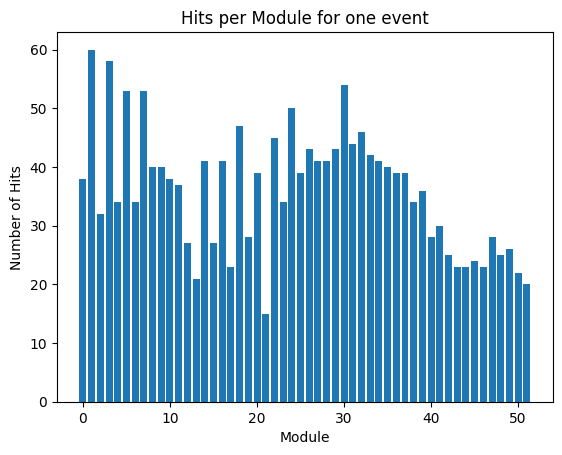

In [291]:
hits_per_module = [cumulative_sum[i] - cumulative_sum[i-1] for i in range(1, len(cumulative_sum))]
print(len(hits_per_module))

plt.bar(range(len(hits_per_module)), hits_per_module)
plt.xlabel('Module')
plt.ylabel('Number of Hits')
plt.title('Hits per Module for one event')
plt.show()

### Test with several events

In [385]:
def plot_hits_per_module(events):
    # Calculate cumulative sums across all events
    cumulative_sums = np.sum([event.module_prefix_sum for event in events], axis=0)
    
    # Calculate hits per module
    hits_per_module = [cumulative_sums[0]] + [cumulative_sums[i+1] - cumulative_sums[i] for i in range(len(cumulative_sums)-1)]
    
    # Plot histogram
    plt.bar(range(len(hits_per_module)), hits_per_module)
    plt.xlabel('Module')
    plt.ylabel('Number of Hits')
    plt.title('Hits per module for several events')
    plt.show()


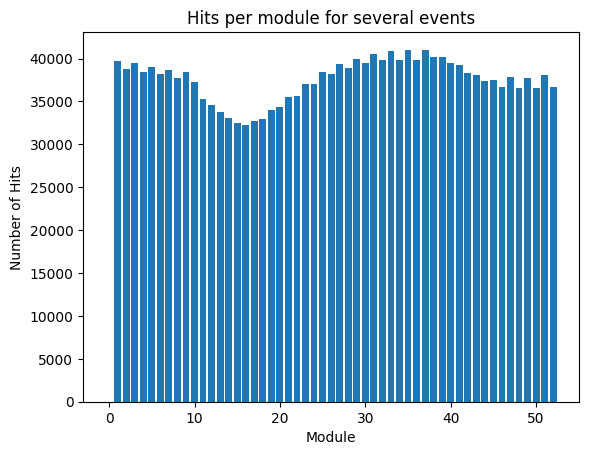

In [409]:
plot_hits_per_module(all_events)

### Mean with several events

In [433]:

def plot_hits_per_module_mean(events):
    all_hits_per_module = []

    for event in events:
        cumulative_sum = event.module_prefix_sum
        hits_per_module = [cumulative_sum[i+1] - cumulative_sum[i] for i in range(len(cumulative_sum)-1)]
        all_hits_per_module.append(hits_per_module)

    mean_hits_per_module = [sum(x)/len(x) for x in zip(*all_hits_per_module)]
    
    avg_hits_per_module = sum(mean_hits_per_module)/len(mean_hits_per_module)


    cmap = plt.cm.Blues
    #cmap = plt.cm.get_cmap('Blues', 5)
    #cmap = ListedColormap(['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6'])
    #cmap = plt.cm.viridis_r

    #norm = plt.Normalize(vmin=30, vmax=45)
    norm = plt.Normalize(vmin=np.min(mean_hits_per_module)-10, vmax=np.max(mean_hits_per_module))

    colors = cmap(norm(mean_hits_per_module))
    #colors = ['tab:blue' if h >= 35 else 'lightblue' for h in mean_hits_per_module]

    plt.bar(range(52), mean_hits_per_module,color = colors, zorder=2)
    plt.xlabel('Module')
    plt.ylabel('Average Number of Hits')
    plt.title('Average hits per module for several events')
    plt.grid(True, color='grey', linewidth=0.5, zorder=1)
    #plt.axhline(y=avg_hits_per_module, color='red', linestyle='--', label='Average Number of Hits per Module: {:.2f}'.format(avg_hits_per_module))
    #plt.legend(loc='best')
    plt.show()

    print("Average hits per module:", avg_hits_per_module)

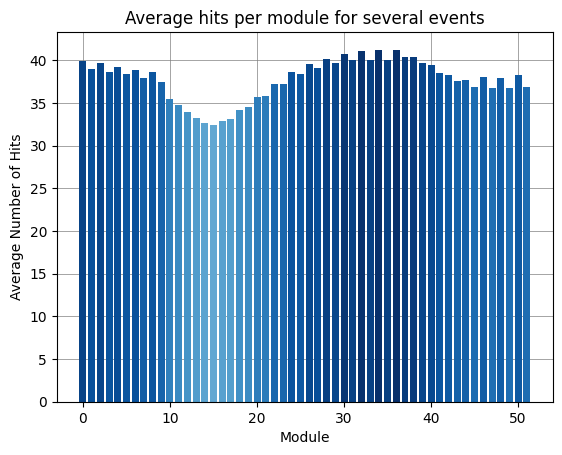

Average hits per module: 37.76685349826053


In [434]:
plot_hits_per_module_mean(all_events)

In [431]:
from matplotlib.colors import ListedColormap

def plot_hits_per_module_mean_var(events):
    all_hits_per_module = []

    for event in events:
        cumulative_sum = event.module_prefix_sum
        hits_per_module = [cumulative_sum[i+1] - cumulative_sum[i] for i in range(len(cumulative_sum)-1)]
        all_hits_per_module.append(hits_per_module)

    mean_hits_per_module = [sum(x)/len(x) for x in zip(*all_hits_per_module)]
    var_hits_per_module = [np.var(x) for x in zip(*all_hits_per_module)]


    avg_hits_per_module = sum(mean_hits_per_module)/len(mean_hits_per_module)


    cmap = plt.cm.Blues
    #cmap = plt.cm.get_cmap('Blues', 5)
    #cmap = ListedColormap(['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6'])
    #cmap = plt.cm.viridis_r

    #norm = plt.Normalize(vmin=30, vmax=45)
    norm = plt.Normalize(vmin=np.min(mean_hits_per_module)-10, vmax=np.max(mean_hits_per_module))

    colors = cmap(norm(mean_hits_per_module))
    #colors = ['tab:blue' if h >= 35 else 'lightblue' for h in mean_hits_per_module]

    plt.bar(range(52), mean_hits_per_module,color = colors, zorder=2)
    plt.errorbar(range(52), mean_hits_per_module, yerr=np.sqrt(var_hits_per_module), color= 'black', fmt='none', capsize=3, zorder=3)

    plt.xlabel('Module')
    plt.ylabel('Average Number of Hits')
    plt.title('Average hits per module for several events')
    plt.grid(True, color='grey', linewidth=0.5, zorder=1)
    #plt.axhline(y=avg_hits_per_module, color='red', linestyle='--', label='Average Number of Hits per Module: {:.2f}'.format(avg_hits_per_module))
    #plt.legend(loc='best')
    plt.show()

    print("Average hits per module:", avg_hits_per_module)

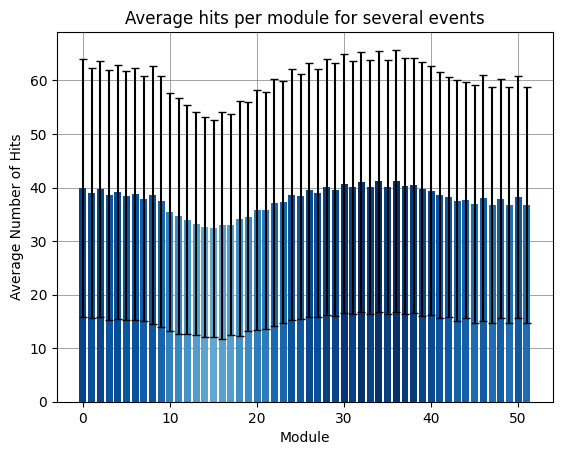

Average hits per module: 37.76685349826053


In [432]:
plot_hits_per_module_mean_var(all_events)